## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

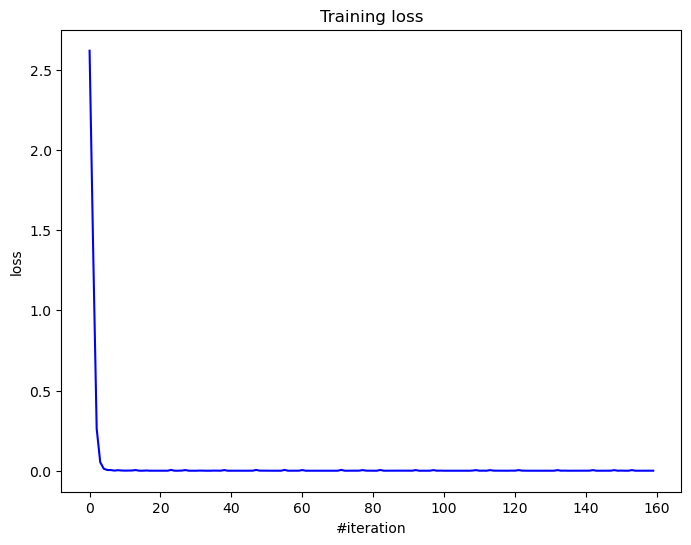

Current loss: 0.000216


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [18]:
#!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [8]:
import numpy as np
import struct
from array import array


def read_images_labels(images_filepath, labels_filepath):
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img

    return images, labels


X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [9]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1


images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [10]:
plt.imshow(X_train[0], cmap='gray')

In [11]:
# Your code goes here. 
from sklearn.preprocessing import OneHotEncoder
num_classes = 10

y_train = np.array(y_train)
y_test = np.array(y_test)

encoder = OneHotEncoder(categories='auto', sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))


print(y_train[:5])
print(y_train_one_hot[:5])

print(y_test[:5])
print(y_test_one_hot[:5])

[5 0 4 1 9]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[7 2 1 0 4]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [12]:
X_train = np.array(X_train).reshape(-1, 28 * 28)  # Преобразование в (n_samples, 784)
X_test = np.array(X_test).reshape(-1, 28 * 28)

X_train = X_train / 255.0
X_test = X_test / 255.0

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 


Функция: ReLU
Эпоха 1: текущая потеря- 0.5709
Эпоха 2: текущая потеря- 0.3734
Эпоха 3: текущая потеря- 0.3564
Эпоха 4: текущая потеря- 0.3192
Эпоха 5: текущая потеря- 0.2860
Эпоха 6: текущая потеря- 0.3270
Эпоха 7: текущая потеря- 0.2348
Эпоха 8: текущая потеря- 0.2898
Эпоха 9: текущая потеря- 0.2372
Эпоха 10: текущая потеря- 0.2436

Функция: ELU
Эпоха 1: текущая потеря- 0.5822
Эпоха 2: текущая потеря- 0.4010
Эпоха 3: текущая потеря- 0.3325
Эпоха 4: текущая потеря- 0.3845
Эпоха 5: текущая потеря- 0.3358
Эпоха 6: текущая потеря- 0.3140
Эпоха 7: текущая потеря- 0.3213
Эпоха 8: текущая потеря- 0.2928
Эпоха 9: текущая потеря- 0.2433
Эпоха 10: текущая потеря- 0.3147

Функция: LeakyReLU
Эпоха 1: текущая потеря- 0.5755
Эпоха 2: текущая потеря- 0.3435
Эпоха 3: текущая потеря- 0.2984
Эпоха 4: текущая потеря- 0.3211
Эпоха 5: текущая потеря- 0.3141
Эпоха 6: текущая потеря- 0.3047
Эпоха 7: текущая потеря- 0.2954
Эпоха 8: текущая потеря- 0.2019
Эпоха 9: текущая потеря- 0.2693
Эпоха 10: текущая пот

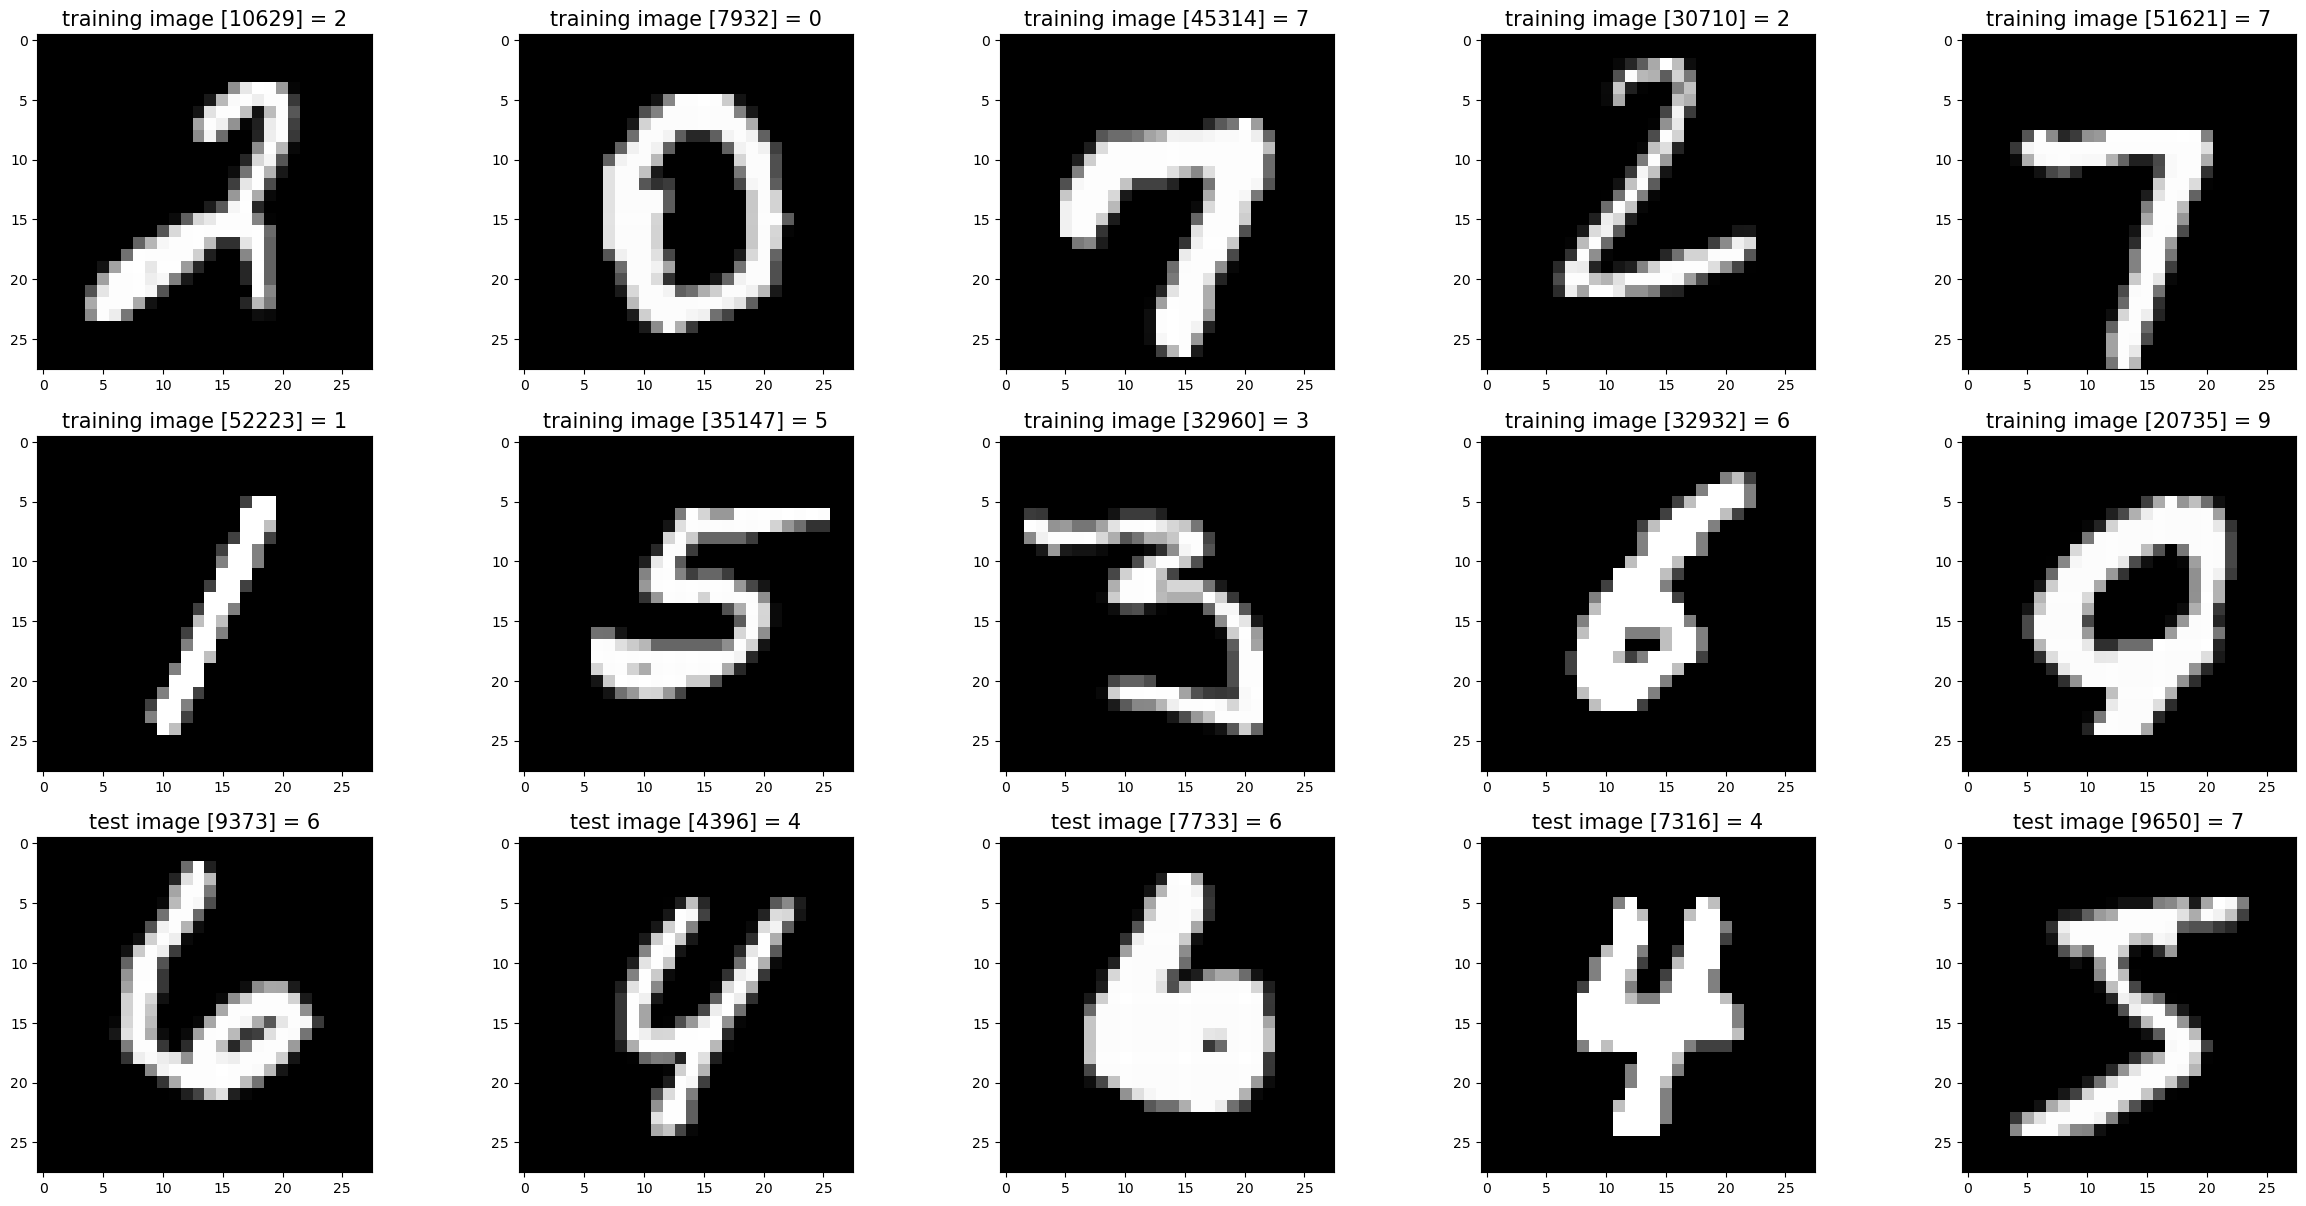

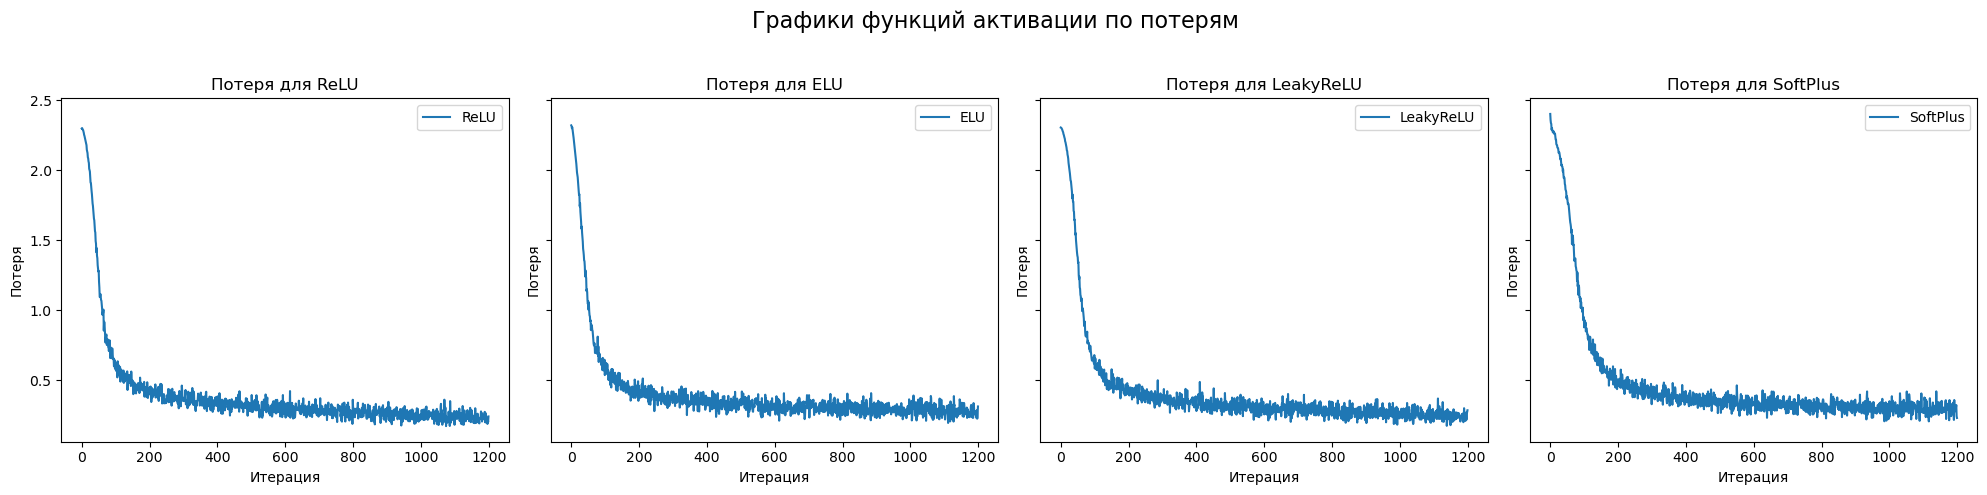

In [13]:
# Your code goes here. ################################################
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}

n_epoch = 10
batch_size = 500

activations = [ReLU(), ELU(alpha=1.0), LeakyReLU(slope=0.1), SoftPlus()]

results = {}
loss_histories = {}
optimizer_state = {}
execution_times = {}

def create_model(activation):
    model = Sequential()
    model.add(Linear(28 * 28, 128))
    model.add(activation)
    model.add(Linear(128, 10))
    model.add(LogSoftMax())
    return model

def train_model(model, X_train, y_train_one_hot):
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            model.zeroGradParameters()
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)

            sgd_momentum(model.getParameters(),
                         model.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

def evaluate_model(model, X_test, y_test_one_hot):
    test_predictions = model.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)

    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy


for activation in activations:
    print(f"\nФункция: {activation}")
    net = create_model(activation)
    loss_history, execution_time = train_model(net, X_train, y_train_one_hot)
    accuracy = evaluate_model(net, X_test, y_test_one_hot)
    results[str(activation)] = {'accuracy': accuracy, 'execution_time': execution_time}
    loss_histories[str(activation)] = loss_history
    execution_times[str(activation)] = execution_time


print("\nСравнения моделей по точности и времени выполнения:")
for activation, metrics in results.items():
    print(f"\nФункция: {activation}")
    print(f"Точность: {metrics['accuracy']:.4f}")
    print(f"Время: {metrics['execution_time']:.2f} секунд")

def plot_loss_histories(loss_histories):
    num_activations = len(loss_histories)
    fig, axes = plt.subplots(1, num_activations, figsize=(20, 5), sharey=True)

    for i, (activation, history) in enumerate(loss_histories.items()):
        axes[i].plot(history, label=str(activation))
        axes[i].set_title(f"Потеря для {activation}")
        axes[i].set_xlabel("Итерация")
        axes[i].set_ylabel("Потеря")
        axes[i].legend()

    plt.suptitle("Графики функций активации по потерям", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_loss_histories(loss_histories)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################
#ReLU:Эта функция является одной из самых популярных из-за своей простоты и эффективности. 
#Она помогает избежать проблемы затухающего градиента и часто приводит к высокой точности (0.9364).
#Однако, она может сталкиваться с проблемой "мертвых нейронов", когда нейрон не обновляется из-за 
#отрицательных входов.
#ELU (Exponential Linear Unit):
#ELU может приводить к более стабильной производительности и быстрому обучению, хотя точность немного ниже, 
#чем у ReLU(0.9240). По времени вычислений, она требует больше ресурсов из-за экспоненциальной функции.
#Leaky ReLU:Эта функция является улучшенной версией ReLU, которая позволяет небольшие отрицательные значения. 
#Она показывает хорошую точность (0.9327) и помогает избежать проблемы мертвых нейронов, но, как и ReLU, 
#может иметь большую скорость обучения.
#СофтПлюс:Эта функция активации имеет наименьшую точность (0.9181) среди рассмотренных, хотя и показывает 
#результаты, близкие к другим функциям. Из-за своей формы, она требует больше времени для вычислений (211.83 секунд).
#Время вычислений. ReLU и Leaky ReLU предпочтительнее, так как они более просты в вычислениях по сравнению 
#с ELU и СофтПлюс.
#Batch Normalization помогает ускорить процесс обучения и стабилизировать его, исправляя распределение 
#входящих данных в каждом слое. Это может уменьшить необходимость в настройке гиперпараметров, таких как 
#скорость обучения.

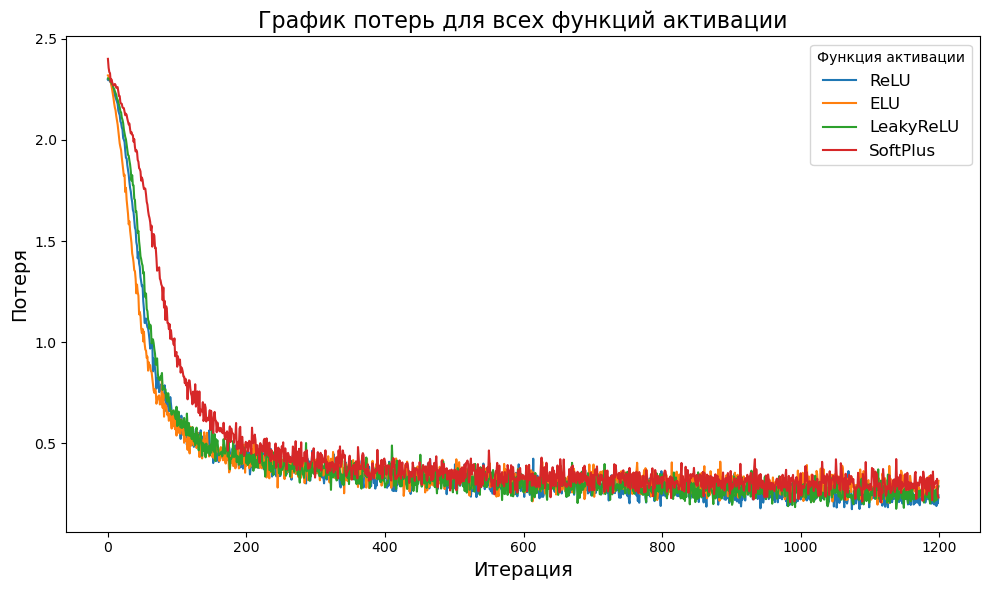

In [14]:
def plot_loss_histories(loss_histories):
    plt.figure(figsize=(10, 6))

    for activation, history in loss_histories.items():
        plt.plot(history, label=str(activation))

    plt.title("График потерь для всех функций активации", fontsize=16)
    plt.xlabel("Итерация", fontsize=14)
    plt.ylabel("Потеря", fontsize=14)
    plt.legend(title="Функция активации", fontsize=12)
    plt.tight_layout()
    plt.show()

plot_loss_histories(loss_histories)

In [15]:
X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train = np.array(X_train).reshape(-1, 28 * 28)
X_test = np.array(X_test).reshape(-1, 28 * 28)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
np.random.seed(42)
def train_model(net, model_name):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()
    optimizer_state = {}

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy


In [17]:
np.random.seed(42)
import time
optimizer_config = {'learning_rate': 1e-2, 'momentum': 0.9}
n_epoch = 10
batch_size = 500
results = {}
loss_histories = {}
execution_times = {}

net_without_norm = Sequential()
net_without_norm.add(Linear(28 * 28, 128))
net_without_norm.add(LeakyReLU(slope=0.1))
net_without_norm.add(Linear(128, 10))
net_without_norm.add(LogSoftMax())

net_with_norm = Sequential()
net_with_norm.add(Linear(28 * 28, 128))
batch_norm_0 = BatchNormalization(128)
batch_norm_0.alpha = 0.9
net_with_norm.add(batch_norm_0)
net_with_norm.add(ChannelwiseScaling(128))
net_with_norm.add(LeakyReLU(slope=0.1))
net_with_norm.add(Linear(128, 10))
net_with_norm.add(LogSoftMax())

np.random.seed(42)
print("\nБез нормализации:")
loss_without_norm, time_without_norm = train_model(net_without_norm, "Без нормализации")
np.random.seed(42)
print("\nС нормализацией:")
loss_with_norm, time_with_norm = train_model(net_with_norm, "С нормализацией")

accuracy_without_norm = evaluate_model(net_without_norm, "Без нормализации")
accuracy_with_norm = evaluate_model(net_with_norm, "С нормализацией")

print("\nРезультаты сравнения моделей:")

print("\nБез нормализации")
print(f"Точность: {accuracy_without_norm:.4f}")
print(f"Время: {time_without_norm:.2f} секунд")

print("\nС нормализацией")
print(f"Точность: {accuracy_with_norm:.4f}")
print(f"Время: {time_with_norm:.2f} секунд")


Без нормализации:
Эпоха 1: текущая потеря- 0.5413
Эпоха 2: текущая потеря- 0.4076
Эпоха 3: текущая потеря- 0.3824
Эпоха 4: текущая потеря- 0.3207
Эпоха 5: текущая потеря- 0.3535
Эпоха 6: текущая потеря- 0.2909
Эпоха 7: текущая потеря- 0.2722
Эпоха 8: текущая потеря- 0.3243
Эпоха 9: текущая потеря- 0.2830
Эпоха 10: текущая потеря- 0.2574

С нормализацией:
Эпоха 1: текущая потеря- 1.5632
Эпоха 2: текущая потеря- 0.4952
Эпоха 3: текущая потеря- 0.3591
Эпоха 4: текущая потеря- 0.2833
Эпоха 5: текущая потеря- 0.2792
Эпоха 6: текущая потеря- 0.2368
Эпоха 7: текущая потеря- 0.1989
Эпоха 8: текущая потеря- 0.2380
Эпоха 9: текущая потеря- 0.2178
Эпоха 10: текущая потеря- 0.1850

Результаты сравнения моделей:

Без нормализации
Точность: 0.9308
Время: 222.21 секунд

С нормализацией
Точность: 0.9507
Время: 231.20 секунд


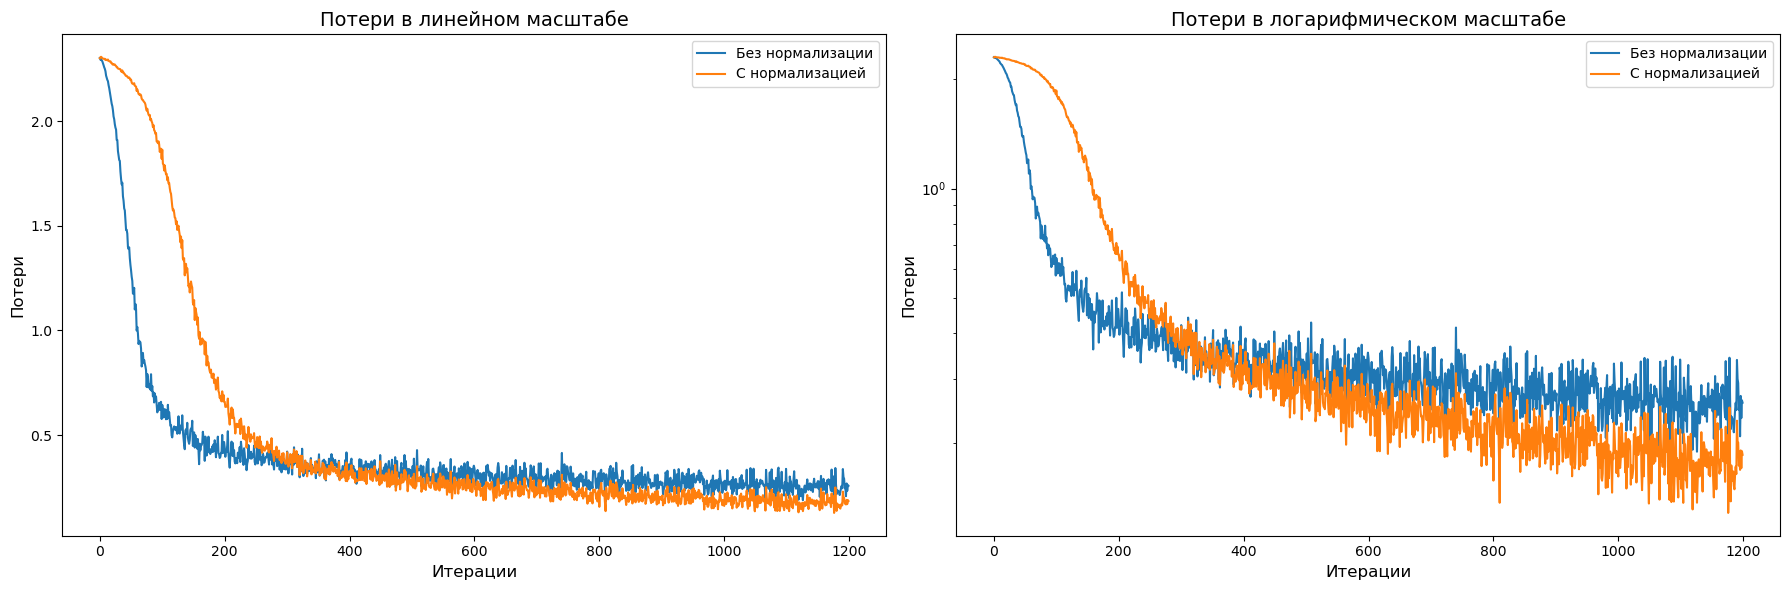

In [18]:
loss_histories["Без нормализации"] = loss_without_norm
loss_histories["С нормализацией"] = loss_with_norm

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 строка, 2 столбца

for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

axes[1].set_yscale("log")

axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

plt.tight_layout()

plt.show()

In [19]:
X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train = np.array(X_train).reshape(-1, 28 * 28)
X_test = np.array(X_test).reshape(-1, 28 * 28)

X_train = X_train / 255.0
X_test = X_test / 255.0

def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_one_hot = one_hot_encode(y_train, 10)
y_test_one_hot = one_hot_encode(y_test, 10)

In [20]:
def train_model(net, model_name, optimizer, optimizer_config):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()
    optimizer_state = {}

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

In [21]:
def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy

In [22]:
np.random.seed(42)
optimizer_config_sgd = {'learning_rate': 1e-2, 'momentum': 0.9}

optimizer_config_adam = {
    'learning_rate': 1e-3,
    'beta1': 0.9,       
    'beta2': 0.999,     
    'epsilon': 1e-8 
}

n_epoch = 10
batch_size = 500

net_adam = Sequential()
net_adam.add(Linear(28 * 28, 128))
net_adam.add(LeakyReLU(slope=0.1))
net_adam.add(Linear(128, 10))
net_adam.add(LogSoftMax())

net_adam_norm = Sequential()
net_adam_norm.add(Linear(28 * 28, 128))
batch_norm_1 = BatchNormalization(128)
batch_norm_1.alpha = 0.9
net_adam_norm.add(batch_norm_1)
net_adam_norm.add(ChannelwiseScaling(128))
net_adam_norm.add(LeakyReLU(slope=0.1))
net_adam_norm.add(Linear(128, 10))
net_adam_norm.add(LogSoftMax())

print("\nAdam с нормализацией:")
loss_adam_norm, time_adam_norm = train_model(net_adam_norm, "Adam", adam_optimizer, optimizer_config_adam)

print("\nAdam:")
loss_adam, time_adam = train_model(net_adam, "Adam", adam_optimizer, optimizer_config_adam)



Adam с нормализацией:
Эпоха 1: текущая потеря- 0.7325
Эпоха 2: текущая потеря- 0.4217
Эпоха 3: текущая потеря- 0.2782
Эпоха 4: текущая потеря- 0.2959
Эпоха 5: текущая потеря- 0.1723
Эпоха 6: текущая потеря- 0.1859
Эпоха 7: текущая потеря- 0.1411
Эпоха 8: текущая потеря- 0.2199
Эпоха 9: текущая потеря- 0.1076
Эпоха 10: текущая потеря- 0.1076

Adam:
Эпоха 1: текущая потеря- 0.3254
Эпоха 2: текущая потеря- 0.2784
Эпоха 3: текущая потеря- 0.2304
Эпоха 4: текущая потеря- 0.1838
Эпоха 5: текущая потеря- 0.1844
Эпоха 6: текущая потеря- 0.1567
Эпоха 7: текущая потеря- 0.0967
Эпоха 8: текущая потеря- 0.0912
Эпоха 9: текущая потеря- 0.0996
Эпоха 10: текущая потеря- 0.0974


In [23]:
accuracy_adam = evaluate_model(net_adam, "Adam")
accuracy_adam_norm = evaluate_model(net_adam_norm, "Adam с нормализацией")

print("\nРезультаты сравнения моделей:")
print("\nAdam")
print(f"Точность: {accuracy_adam:.4f}")
print(f"Время: {time_adam:.2f} секунд")

print("\nAdam с нормализацией")
print(f"Точность: {accuracy_adam_norm:.4f}")
print(f"Время: {time_adam_norm:.2f} секунд")


Результаты сравнения моделей:

Adam
Точность: 0.9640
Время: 223.50 секунд

Adam с нормализацией
Точность: 0.9641
Время: 228.82 секунд


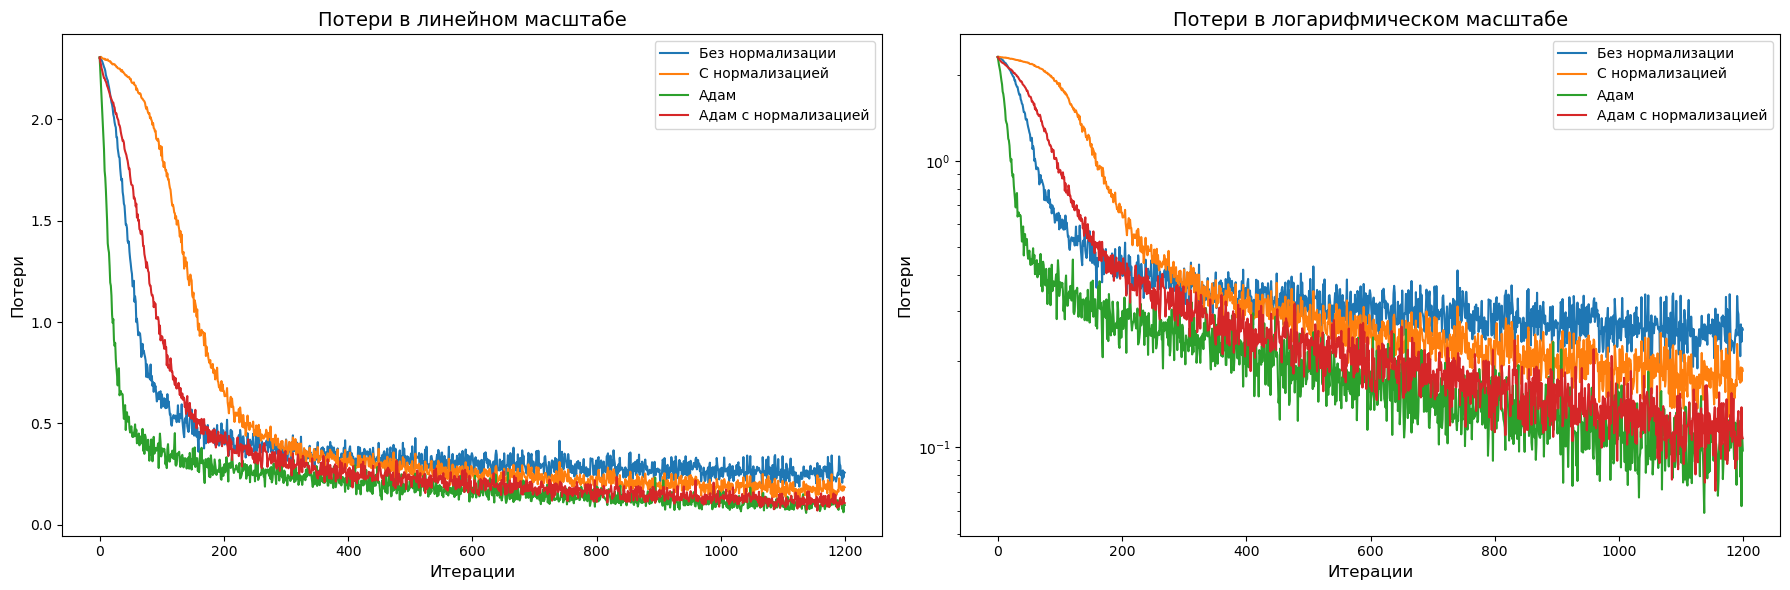

In [24]:
loss_histories["Адам"] = loss_adam
loss_histories["Адам с нормализацией"] = loss_adam_norm

fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 

for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

axes[1].set_yscale("log")

axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

plt.tight_layout()

plt.show()


In [ ]:
#Модель с применением нормализации достигла точности 0.9507, что значительно выше по сравнению с точностью без нее,
#которая составила 0.9308. Это свидетельствует о том, что нормализация положительно сказалась на эффективности 
#модели.
#Время выполнения с нормализацией составило 327.90 секунд, что больше, чем 323.54 секунды без нормализации.
#Модель с нормализацией продемонстрировала более высокую точность (0.9507 против 0.9308), 
#что является важным аспектом в большинстве задач машинного обучения. 
#модель с нормализацией в целом следует считать более предпочтительной, так как она обеспечивает лучшие результаты 
#с минимальными затратами времени.

In [ ]:
#для Adam нормализация повышает точность всего на  0.0001, что является несущественным и увеличивает время. 

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

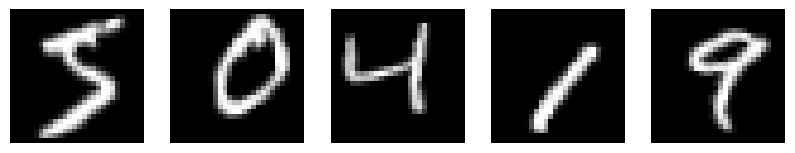

In [25]:
# Your code goes here. ################################################
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")
X_train_r = np.array(X_train).reshape(-1, 28, 28, 1)
X_test = np.array(X_test).reshape(-1, 28 * 28) / 255.0

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

aug_X_train = []
aug_y_train = []

for x_batch, y_batch in datagen.flow(X_train_r, y_train, batch_size=500, shuffle=False):
    aug_X_train.append(x_batch)
    aug_y_train.append(y_batch)
    if len(aug_X_train) * 500 >= len(X_train):
        break

aug_X_train = np.concatenate(aug_X_train, axis=0).reshape(-1, 28 * 28)
aug_y_train = np.concatenate(aug_y_train, axis=0).astype(int)  # Приводим к int

y_train_one_hot = np.eye(num_classes)[aug_y_train]

X_train = aug_X_train / 255.0

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(aug_X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [26]:
def train_model(net, model_name, optimizer, optimizer_config):
    net.train()
    criterion = ClassNLLCriterion()
    loss_history = []
    start_time = time.time()
    optimizer_state = {}

    for epoch in range(n_epoch):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            x_batch = X_train[indices[start:end]]
            y_batch = y_train_one_hot[indices[start:end]]

            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            optimizer(net.getParameters(),
                      net.getGradParameters(),
                      optimizer_config,
                      optimizer_state)

            loss_history.append(loss)

        print(f"Эпоха {epoch + 1}: текущая потеря- {loss:.4f}")

    execution_time = time.time() - start_time
    return loss_history, execution_time

In [27]:
def evaluate_model(net, model_name):
    net.evaluate()
    test_predictions = net.forward(X_test)
    test_classes = np.argmax(test_predictions, axis=1)
    test_labels_classes = np.argmax(y_test_one_hot, axis=1)
    accuracy = np.mean(test_classes == test_labels_classes)
    return accuracy

In [28]:
np.random.seed(42)
optimizer_config_sgd = {'learning_rate': 0.001, 'momentum': 0.9}

optimizer_config_adam = {
    'learning_rate': 0.001,
    'beta1': 0.9,       
    'beta2': 0.999,    
    'epsilon': 1e-8     
}

n_epoch = 10
batch_size = 500

best_net = Sequential()
best_net.add(Linear(28 * 28, 128))
best_net.add(LeakyReLU(slope=0.1))
best_net.add(Dropout(0.1))
best_net.add(Linear(128, 64))
batch_norm_2 = BatchNormalization(64)
batch_norm_2.alpha = 0.9
best_net.add(batch_norm_2)
best_net.add(ChannelwiseScaling(64))
best_net.add(LeakyReLU(slope=0.1))
best_net.add(Linear(64, 10))
best_net.add(LogSoftMax())

print("\nОбучение Best Net:")
loss_best_net, time_best_net = train_model(best_net, "Best Net", adam_optimizer, optimizer_config_adam)


Обучение Best Net:
Эпоха 1: текущая потеря- 1.0948
Эпоха 2: текущая потеря- 0.4052
Эпоха 3: текущая потеря- 0.3560
Эпоха 4: текущая потеря- 0.2284
Эпоха 5: текущая потеря- 0.2282
Эпоха 6: текущая потеря- 0.2396
Эпоха 7: текущая потеря- 0.1534
Эпоха 8: текущая потеря- 0.1491
Эпоха 9: текущая потеря- 0.1211
Эпоха 10: текущая потеря- 0.1875


In [29]:
accuracy_best_net = evaluate_model(best_net, "Best Net")

print(f"\nТочность на тестовых данных: {accuracy_best_net:.4f}")
print(f"Время обучения: {time_best_net:.2f} секунд")


Точность на тестовых данных: 0.9739
Время обучения: 245.79 секунд


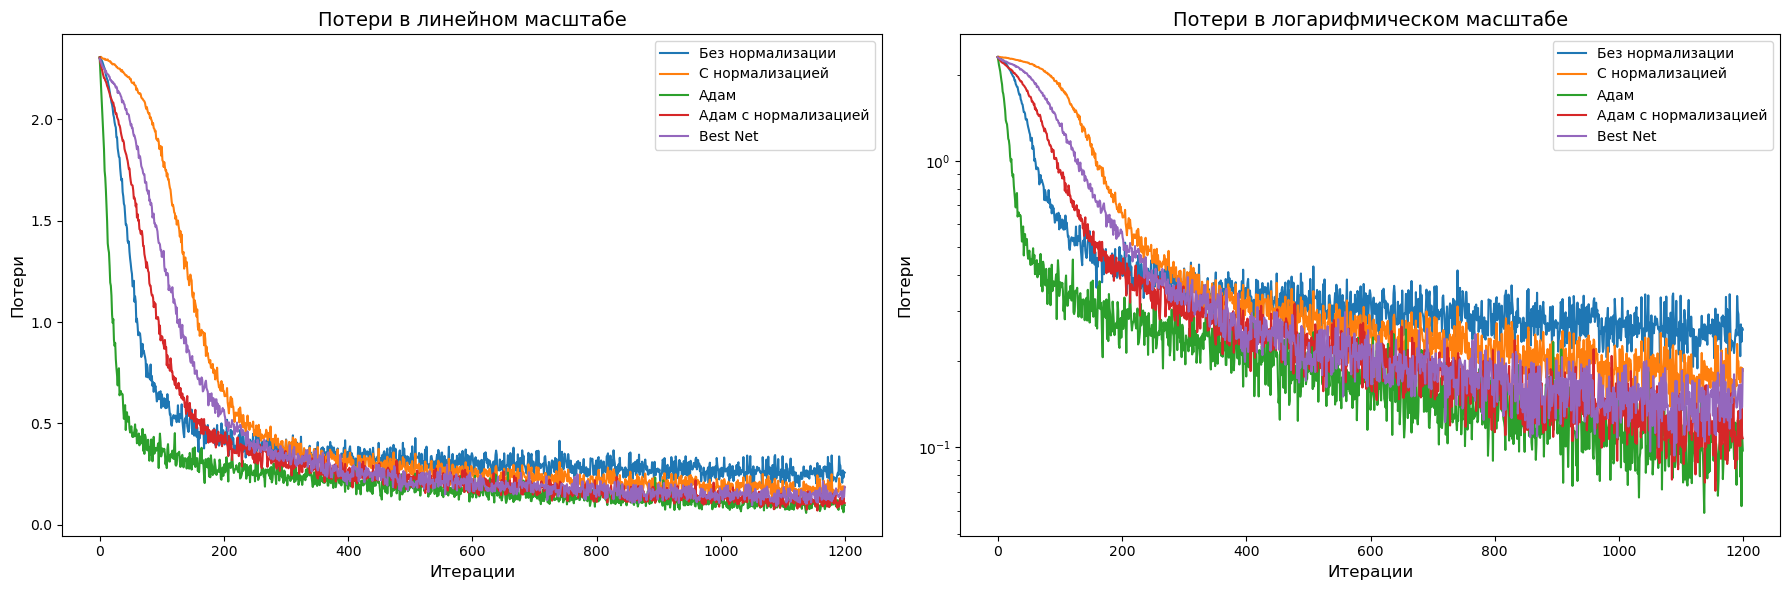

In [30]:
loss_histories["Best Net"] = loss_best_net

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 строка, 2 столбца

for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

axes[1].set_yscale("log")

axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

plt.tight_layout()

plt.show()

Print here your accuracy on test set. It should be around 90%.

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [31]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import struct

In [32]:
def read_images_labels(image_path, label_path):
    with open(image_path, 'rb') as f:
        magic_number, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows * cols)
    with open(label_path, 'rb') as f:
        magic_number, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return images, labels

def preprocess_data(X_train, X_test):
    X_train = np.array(X_train).reshape(-1, 28, 28) / 255.0
    X_test = np.array(X_test).reshape(-1, 28, 28) / 255.0
    return X_train, X_test

X_train, y_train = read_images_labels("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
X_test, y_test = read_images_labels("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

X_train, X_test = preprocess_data(X_train, X_test)

In [33]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 28*28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 28*28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

In [35]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.2)  
        self.batch_norm = nn.BatchNorm1d(128)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)  
        x = self.fc2(x)
        return self.softmax(x)

In [36]:
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [37]:
def train_model(model, train_loader, optimizer, criterion, n_epochs=10):
    model.train()
    epoch_loss_history = []
    iteration_loss_history = [] 
    start_time = time.time()

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            iteration_loss_history.append(loss.item()) 

        avg_loss = running_loss / len(train_loader)
        epoch_loss_history.append(avg_loss) 
        print(f"Эпоха {epoch+1}, потеря: {avg_loss:.4f}")

    execution_time = time.time() - start_time
    return epoch_loss_history, iteration_loss_history, execution_time

In [38]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [39]:
epoch_loss_history, iteration_loss_history, train_time = train_model(model, train_loader, optimizer, criterion)

accuracy = evaluate_model(model, test_loader)

Эпоха 1, потеря: 0.5288
Эпоха 2, потеря: 0.2495
Эпоха 3, потеря: 0.1974
Эпоха 4, потеря: 0.1654
Эпоха 5, потеря: 0.1448
Эпоха 6, потеря: 0.1299
Эпоха 7, потеря: 0.1166
Эпоха 8, потеря: 0.1070
Эпоха 9, потеря: 0.1004
Эпоха 10, потеря: 0.0917


In [40]:
print(f"\nТочность на тестовых данных: {accuracy:.4f}")
print(f"Время обучения: {train_time:.2f} секунд")


Точность на тестовых данных: 0.9734
Время обучения: 7.17 секунд


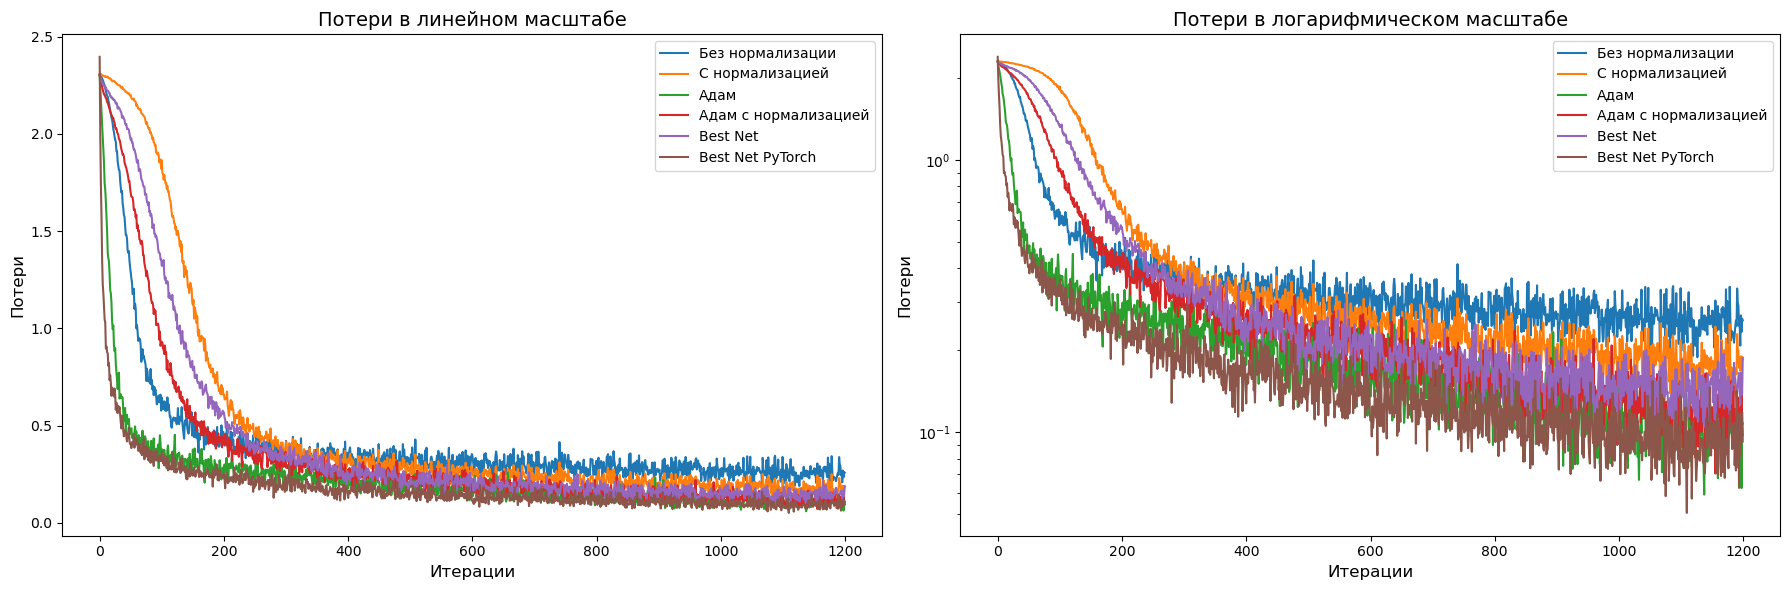

In [41]:
loss_histories["Best Net PyTorch"] = iteration_loss_history

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for model_name, history in loss_histories.items():
    axes[0].plot(history, label=model_name)

axes[0].set_xlabel("Итерации", fontsize=12)
axes[0].set_ylabel("Потери", fontsize=12)
axes[0].set_title("Потери в линейном масштабе", fontsize=14)
axes[0].legend(fontsize=10)

for model_name, history in loss_histories.items():
    axes[1].plot(history, label=model_name)

axes[1].set_yscale("log")

axes[1].set_xlabel("Итерации", fontsize=12)
axes[1].set_ylabel("Потери", fontsize=12)
axes[1].set_title("Потери в логарифмическом масштабе", fontsize=14)
axes[1].legend(fontsize=10)

plt.tight_layout()

plt.show()